In [1]:
# import packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import datetime
from statsmodels import robust 
import scipy.stats as stats
# NB: if commented out, not used. NYC included. Might re-use.

In [2]:
# import relevant data
# obtained from https://aqicn.org/data-platform/covid19/ 
#AQI_19 = pd.read_excel('waqi-covid19-airqualitydata.xlsx') 
# NYT: https://github.com/nytimes/covid-19-data
Covid_us = pd.read_excel('us-counties.xlsx')
# source: https://aqicn.org/data-platform/register/
AQI = pd.read_excel('los-angeles-north main street-air-quality.xlsx') # AQI for LA in the past 76 months

In [3]:
# no2 during 19 & 20
time20 = datetime.datetime(2020,1,1,0,0,0) # 2020,1,1,end point
time19 = datetime.datetime(2019,1,1,0,0,0) # 2019,1,1

AQI_19 = (AQI[(AQI.date < time20)&(AQI.date >= time19)].reset_index()).iloc[:,1:] # 2019
AQI_20 = (AQI[AQI.date >= time20].reset_index()).iloc[:,1:] # during 2020
# no2 during 2019
AQI_19 = AQI_19[(AQI_19.date >= '2019-01-26')&(AQI_19.date <= '2019-04-10')].sort_values('date').reset_index(drop = True) # !! drop original index
AQI_19.date = pd.Series(i[0] for i in pd.Series(np.datetime_as_string(AQI_19.date)).str.split('T')) 
AQI_19.date = AQI_19.date.apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m/%d'))# re-formalize date
AQI_19.set_index('date',inplace = True)

# no2 during COVID-19 (2020)
AQI_20 = AQI_20[(AQI_20.date >= '2020-01-26')&(AQI_20.date <= '2020-04-10')&(AQI_20.date !='2020-02-29')].sort_values('date').reset_index(drop = True)
# drop 02/29 so that comparable
AQI_20.date = pd.Series(i[0] for i in pd.Series(np.datetime_as_string(AQI_20.date)).str.split('T'))
AQI_20.date = AQI_20.date.apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m/%d'))
AQI_20.set_index('date',inplace = True)

In [4]:
# select US and NO2 from the large dataset covering the globe and other species
#AQI_19_US = AQI_19[AQI_19.Country == 'US']
#AQI_19_US = AQI_19_US[AQI_19_US.Specie == 'no2']
Covid_county_date = Covid_us.sort_values(['county','date'])
city = ['New York City','Los Angeles'] # city to use. Not use NYC due to limited time range
#city2 = ['Manhattan','Brooklyn','The Bronx','Queens','Staten Island']  # AQI seperates NYC into boroughs
Covid_cities = Covid_county_date[Covid_county_date.county.isin(city)].set_index('county') # only keep 2 cities
#AQI_NYC = AQI_19_US[AQI_19_US.City.isin(city2)].iloc[:,:-2].groupby('Date').mean().reset_index()
#AQI_NYC['City'] = 'New York City'
#AQI_LA = AQI_19_US[AQI_19_US.City == 'Los Angeles'].iloc[:,:-2]
#CA_NYC = pd.merge(Covid_cities[Covid_cities.index == city[0]],AQI_NYC,how = 'inner',left_on='date',right_on = 'Date').set_index('date')
#CA_LA = pd.merge(Covid_cities[Covid_cities.index == city[1]],AQI_LA,how = 'inner',left_on='date',right_on = 'Date').set_index('date')
CA_LA = Covid_cities[Covid_cities.index == city[1]].reset_index(drop = True)
CA_LA.date = pd.Series(i[0] for i in pd.Series(np.datetime_as_string(CA_LA.date)).str.split('T'))
CA_LA.date = CA_LA.date.apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%m/%d'))
CA_LA.reset_index(inplace = True)

<IPython.core.display.Javascript object>


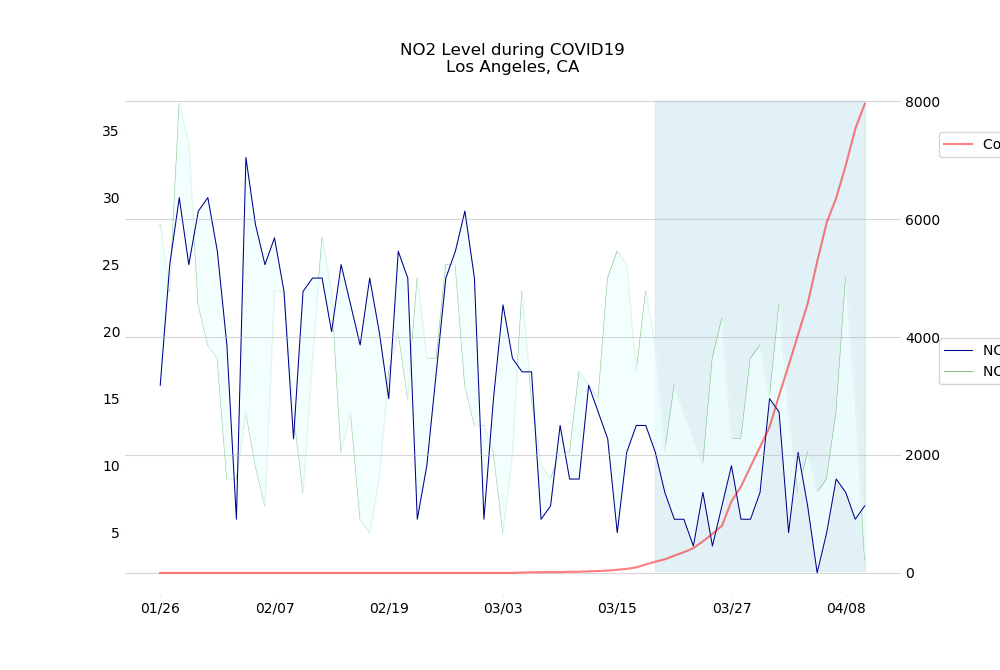

In [9]:
# plot no2 & cases of COVID19
%matplotlib notebook 
# plot no2 19 & 20
fig, ax1 = plt.subplots(figsize = (10,6.7),sharey = True)
no2_20 = plt.plot(AQI_20[' no2'],zorder = 10,color ='darkblue',linewidth = .75,label = 'NO2 level, 2020') # keep LA due to time range
no2_19 = plt.plot(AQI_19[' no2'],alpha = .5,color = 'green',linewidth = .75,label = 'NO2 level, 2019')
# fill between 
x = range(len(AQI_19))
y1 = np.array(AQI_19[' no2'],dtype ='float')
y2 = np.array(AQI_20[' no2'],dtype = 'float')
plt.fill_between(x,y1,y2,color = 'azure',alpha = .75,zorder = 10)

# set x ticks
x_ticks = pd.Series(np.arange(0,len(AQI_20),12)).apply(lambda x:AQI_20.index[x])
ax1.set_xticks(ticks = x_ticks)

# Covid19 cased 01/26 to 04/10
ax2 = ax1.twinx()
cases = ax2.plot(CA_LA.cases,color = 'red',alpha = .5,zorder = 5,label = 'Covid19 cases')

# set yticks for ax2
yticks = np.array([0,2e3,4e3,6e3,8e3])
ax2.set_yticks(ticks = yticks)

# hide axes, show grid and ticklabels
plt.grid(alpha = .5)
for i in ['top','bottom','left','right']:
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
ax1.tick_params(axis=u'both', which=u'both',length=0.1)
ax2.tick_params(axis=u'both', which=u'both',length=0.1)

# title, legend, time range
ax1.axvspan('03/19','04/10', ymin = .05,ymax = .96,alpha=0.35, color='lightblue',zorder = 1) # after lock-down
plt.title('NO2 Level during COVID19\nLos Angeles, CA')
ax1.legend(bbox_to_anchor=(1.05, .5), loc='upper left', borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, .9), loc='upper left', borderaxespad=0.)

NormaltestResult(statistic=27.406269673321106, pvalue=1.118933188713437e-06)